In [1]:
import sys
sys.path.append('./')
sys.path.append('../')

from interventions import three_operands

from transformers import AutoTokenizer, AutoModelForCausalLM
from omegaconf import DictConfig, OmegaConf
from tqdm.notebook import tqdm
import torch
import random
import yaml
import numpy as np
import pickle
import seaborn as sns

from llm_transparency_tool.models.tlens_model import TransformerLensTransparentLlm
from llm_transparency_tool.models.transparent_llm import ModelInfo
from llm_transparency_tool.routes.graph import GraphBuilder, build_full_graph, build_paths_to_predictions
import networkx as nx

import matplotlib.pyplot as plt
import warnings

%matplotlib inline

Matplotlib created a temporary cache directory at /scratch_local/esx208-1097358/tmp/matplotlib-94pj3848 because the default path (/scratch_local/eickhoff/esx208/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig error: Cannot load default config file: No such file: (null)
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories


In [2]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.set_grad_enabled(False)

In [3]:
# model_name = 'EleutherAI/pythia-12b-deduped-v0'
# model_name_lens = 'pythia-12b-deduped-v0'
# model_name = 'EleutherAI/pythia-6.9b-deduped-v0'
# model_name_lens = 'pythia-6.9b-deduped-v0'
# model_name = 'facebook/opt-1.3b'
# model_name_lens = 'opt-1.3b'
# model_name = 'openai-community/gpt2'
# model_name_lens = 'gpt2'
model_name = 'facebook/opt-6.7b'
model_name_lens = 'opt-6.7b'
# model_name = 'facebook/opt-2.7b'
# model_name_lens = 'opt-2.7b'
# model_name = 'facebook/opt-13b'
# model_name_lens = 'opt-13b'

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(
#     model_name,
#     torch_dtype=torch.float16,
#     device_map="auto"
# )

/scratch_local/esx208-1097358/ir_mech_interp/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
conf = OmegaConf.load('./conf/config.yaml')
conf.model = model_name
# conf.max_n = 9
conf.max_n = 20
# conf.n_shots = 1
intervention_list = three_operands.get_arithmetic_data_three_operands(tokenizer, conf)
# intervention_l9ist = pickle.load(open('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/intervention_1_shots_max_20_arabic_further_templates.pkl', 'rb'))
# intervention_list = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_opt_6_7b_old/intervention_list.pkl')

  0%|                                                                                                                                                                                                                                                                                                                       | 0/210 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 85/210 [00:00<00:00, 849.34it/s]

res base: 14
res base wo whitespace: 4
res base with prefix: a 14
res base tok: ['a', 'Ġ14']
operands_base:  ('3', '5', '6')
base string tok list:  [306, 2055, 204, 2055, 231, 5457, 501, 4, 155, 2055, 195, 2055, 231, 5457]
z_base_tok:  231
y_base_tok:  195
x_base_tok:  155
res base: 17
res base wo whitespace: 7
res base with prefix: a 17
res base tok: ['a', 'Ġ17']
operands_base:  ('3', '7', '7')
base string tok list:  [246, 2055, 132, 2055, 290, 5457, 508, 4, 155, 2055, 262, 2055, 262, 5457]
z_base_tok:  262
y_base_tok:  262
x_base_tok:  155
res base: 12
res base wo whitespace: 2
res base with prefix: a 12
res base tok: ['a', 'Ġ12']
operands_base:  ('8', '2', '2')
base string tok list:  [306, 2055, 132, 2055, 290, 5457, 501, 4, 290, 2055, 132, 2055, 132, 5457]
z_base_tok:  132
y_base_tok:  132
x_base_tok:  290
res base: 14
res base wo whitespace: 4
res base with prefix: a 14
res base tok: ['a', 'Ġ14']
operands_base:  ('2', '6', '6')
base string tok list:  [698, 2055, 132, 2055, 155, 54

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 170/210 [00:01<00:00, 126.76it/s]

res base: 16
res base wo whitespace: 6
res base with prefix: a 16
res base tok: ['a', 'Ġ16']
operands_base:  ('2', '4', '2')
base string tok list:  [176, 1009, 132, 1009, 204, 5457, 545, 4, 132, 1009, 204, 1009, 132, 5457]
z_base_tok:  132
y_base_tok:  204
x_base_tok:  132
res base: 8
res base wo whitespace: 
res base with prefix: a 8
res base tok: ['a', 'Ġ8']
operands_base:  ('2', '2', '2')
base string tok list:  [176, 1009, 132, 1009, 204, 5457, 545, 4, 132, 1009, 132, 1009, 132, 5457]
z_base_tok:  132
y_base_tok:  132
x_base_tok:  132
res base: 18
res base wo whitespace: 8
res base with prefix: a 18
res base tok: ['a', 'Ġ18']
operands_base:  ('2', '3', '3')
base string tok list:  [246, 1009, 155, 1009, 132, 5457, 504, 4, 132, 1009, 155, 1009, 155, 5457]
z_base_tok:  155
y_base_tok:  155
x_base_tok:  132
res base: 18
res base wo whitespace: 8
res base with prefix: a 18
res base tok: ['a', 'Ġ18']
operands_base:  ('2', '3', '3')
base string tok list:  [176, 1009, 132, 1009, 155, 5457, 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 151.17it/s]

res base: 12
res base wo whitespace: 2
res base with prefix: a 12
res base tok: ['a', 'Ġ12']
operands_base:  ('3', '2', '2')
base string tok list:  [246, 1009, 132, 1009, 155, 5457, 504, 4, 155, 1009, 132, 1009, 132, 5457]
z_base_tok:  132
y_base_tok:  132
x_base_tok:  155
res base: 16
res base wo whitespace: 6
res base with prefix: a 16
res base tok: ['a', 'Ġ16']
operands_base:  ('2', '2', '4')
base string tok list:  [176, 1009, 155, 1009, 155, 5457, 504, 4, 132, 1009, 132, 1009, 204, 5457]
z_base_tok:  204
y_base_tok:  132
x_base_tok:  132
res base: 18
res base wo whitespace: 8
res base with prefix: a 18
res base tok: ['a', 'Ġ18']
operands_base:  ('2', '3', '3')
base string tok list:  [176, 1009, 132, 1009, 155, 5457, 316, 4, 132, 1009, 155, 1009, 155, 5457]
z_base_tok:  155
y_base_tok:  155
x_base_tok:  132
res base: 12
res base wo whitespace: 2
res base with prefix: a 12
res base tok: ['a', 'Ġ12']
operands_base:  ('2', '2', '3')
base string tok list:  [306, 1009, 132, 1009, 132, 54

In [6]:
def calc_accuracy(intervention_list, model):
    accuracy_base = []
    accuracy_alt = []

    accuracy_base_tok = []
    accuracy_alt_tok = []

    for item in tqdm(intervention_list):
        # input_id_base = item.base_string_tok.to(model.device)
        # input_id_base = torch.tensor([tokenizer.bos_token_id] + item.base_string_tok_list).unsqueeze(0).to(model.device)
        
        # For other models
        # input_id_base = torch.tensor(tokenizer.encode(' ' + item.few_shots + item.base_string)).unsqueeze(0).to(model.device)
        # input_id_alt = item.alt_string_tok.to(model.device)
        
        # For other models and for testing the results without padding
        input_id_base = torch.tensor(tokenizer.encode(' ' + item.few_shots + item.base_string)).unsqueeze(0).to(model.device)
        input_id_alt = torch.tensor(tokenizer.encode(' ' + item.base_string)).unsqueeze(0).to(model.device)
        
        # For pythia and for testing the results without padding
        # input_id_base = torch.tensor([tokenizer.bos_token_id] + tokenizer.encode(' ' + item.few_shots + item.base_string)).unsqueeze(0).to(model.device)
        # input_id_alt = torch.tensor([tokenizer.bos_token_id] + tokenizer.encode(' ' + item.base_string)).unsqueeze(0).to(model.device)

        output_base = model.generate(input_id_base, max_new_tokens=1, do_sample=False)[0, -1].cpu().numpy()
        output_alt = model.generate(input_id_alt, max_new_tokens=1, do_sample=False)[0, -1].cpu().numpy()
        output_base_str = tokenizer.decode(output_base)
        output_alt_str = tokenizer.decode(output_alt)
        correct_output_tok = item.res_base_tok[0]
        correct_output_str = item.res_base_string

        # print(output_base, output_alt, correct_output_tok)
        # correct_output_str = int(item.res_base_string)
        print('With icd: ', output_base_str, 'Without icd: ', output_alt_str, 'Correct: ', correct_output_str)
        print(tokenizer.decode(input_id_base[0]))
        print(tokenizer.decode(input_id_alt[0]))
        print('#' * 10)

        try:
            accuracy_base.append(int(output_base_str) == int(correct_output_str))
        except:
            accuracy_base.append(0)
        
        try:
            accuracy_alt.append(int(output_alt_str) == int(correct_output_str))
        except:
            accuracy_alt.append(0)
        
        accuracy_base_tok.append(output_base == correct_output_tok)
        accuracy_alt_tok.append(output_alt == correct_output_tok)

    return accuracy_base, accuracy_alt, accuracy_base_tok, accuracy_alt_tok

accuracy_base, accuracy_alt, accuracy_base_tok, accuracy_alt_tok = calc_accuracy(intervention_list, model)

NameError: name 'model' is not defined

In [6]:
print('Accuracy with icd, numbers equality', np.mean(accuracy_base))
print('Accuracy without icd, numbers equality', np.mean(accuracy_alt))

print('Accuracy with icd, tokens equality', np.mean(accuracy_base_tok))
print('Accuracy without icd, tokens equality', np.mean(accuracy_alt_tok))

Accuracy with icd, numbers equality 0.319047619047619
Accuracy without icd, numbers equality 0.23333333333333334
Accuracy with icd, tokens equality 0.319047619047619
Accuracy without icd, tokens equality 0.23333333333333334


In [ ]:
# torch.save(intervention_list, '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_6_7b/intervention_list.pkl')
# torch.save(accuracy_base, '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_6_7b/accuracy_base.pkl')

In [7]:
intervention_list = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_6_7b/intervention_list.pkl')
accuracy_base = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_6_7b/accuracy_base.pkl')

/scratch_local/esx208-1097358/tmp/ipykernel_563378/4032278458.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  intervention_list = torch.load('/mnt/qb/work/eickhoff/esx20

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [9]:
model_transparent = TransformerLensTransparentLlm(
    model_name=model_name_lens,
    device='gpu'
)

In [10]:
threshold = 0.035
contribution_graphs = []

for i, item in enumerate(tqdm(accuracy_base)):
    if item == 1:  # Only process cases where the prediction is correct
        # Construct the input message
        msg = ' ' + intervention_list[i].few_shots + intervention_list[i].base_string
        model_transparent.run(msg)
        graph = build_full_graph(model_transparent, renormalizing_threshold=threshold)
        
        tokens = model_transparent.tokens()[0]
        n_tokens = tokens.shape[0]
        model_info = model_transparent.model_info()
        paths = build_paths_to_predictions(
            graph,
            model_info.n_layers,
            n_tokens,
            range(n_tokens),
            threshold,
        )
        
        contribution_graphs.append((graph.copy(), paths[-1], tokens.cpu().numpy()))

  0%|          | 0/210 [00:00<?, ?it/s]

2025-01-28 14:24:29.180 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-28 14:24:29.458 
  command:

    streamlit run /scratch_local/esx208-1097358/ir_mech_interp/lib/python3.9/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-01-28 14:24:29.459 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-28 14:24:29.459 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-28 14:24:29.960 Thread 'Thread-7': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-28 14:24:29.961 Thread 'Thread-7': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/scratch_local/esx208-1097358/ir_mech_interp/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
2025-01-28 14:25:46.526 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-28 14:25:46.528 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Loaded pretrained model opt-6.7b into HookedTransformer


In [11]:
def set_positions(graph):
    all_x_pos = [int(node.split('_')[1]) for node in graph.nodes]
    sorted_pos = sorted(set(all_x_pos))
    number_to_position = {num: idx for idx, num in enumerate(sorted_pos)}
    
    positions = {}
    for node in graph.nodes:
        x_pos =  number_to_position[int(node.split('_')[1])]
        y_pos = int(node.split('_')[0][1:])
        label = node.split('_')[0][0]
        if label == 'A':
            y_pos -= 0.3
        elif label == 'M':
            x_pos += 0.3
        elif label == 'I':
            y_pos += 0.3
        elif label == 'X':
            y_pos -= 1
        positions[node] = [x_pos, y_pos]
    return positions

def plot_single_graph(whole_graph, path, tokens):
    positions = set_positions(whole_graph)

    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(whole_graph, node_color='blue', pos=positions, node_size=50)
    nx.draw(path, node_color='red', pos=positions, node_size=50)

    plt.axis("on")
    plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.xticks(ticks=range(len(tokens)), labels=tokens, rotation=90)
    plt.show()

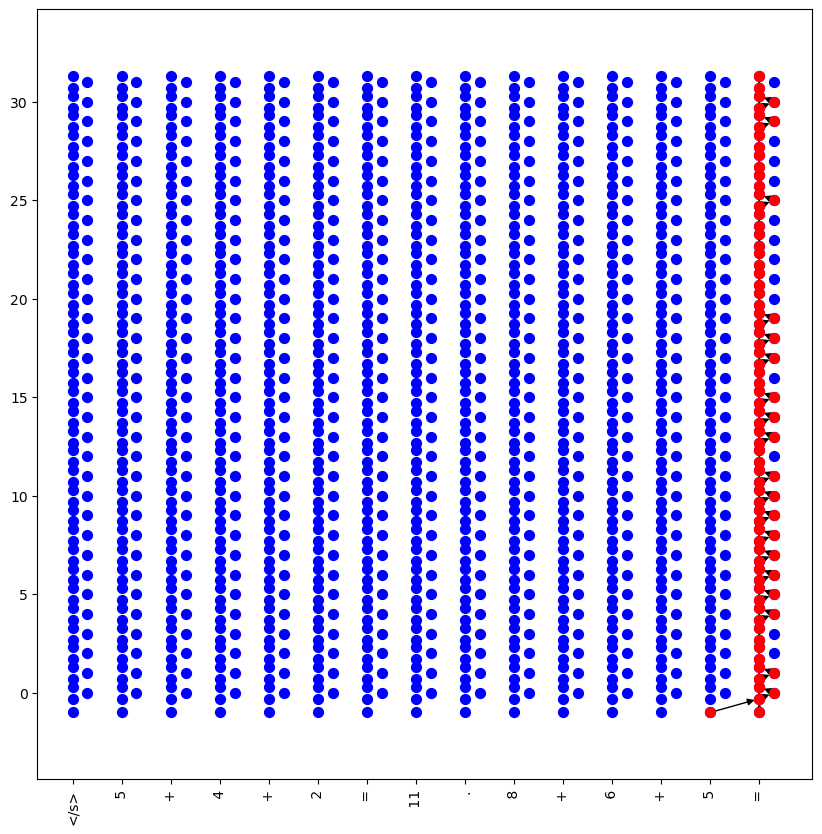

In [12]:
plot_single_graph(contribution_graphs[0][0], contribution_graphs[0][1], [tokenizer.decode(token) for token in contribution_graphs[0][2]])

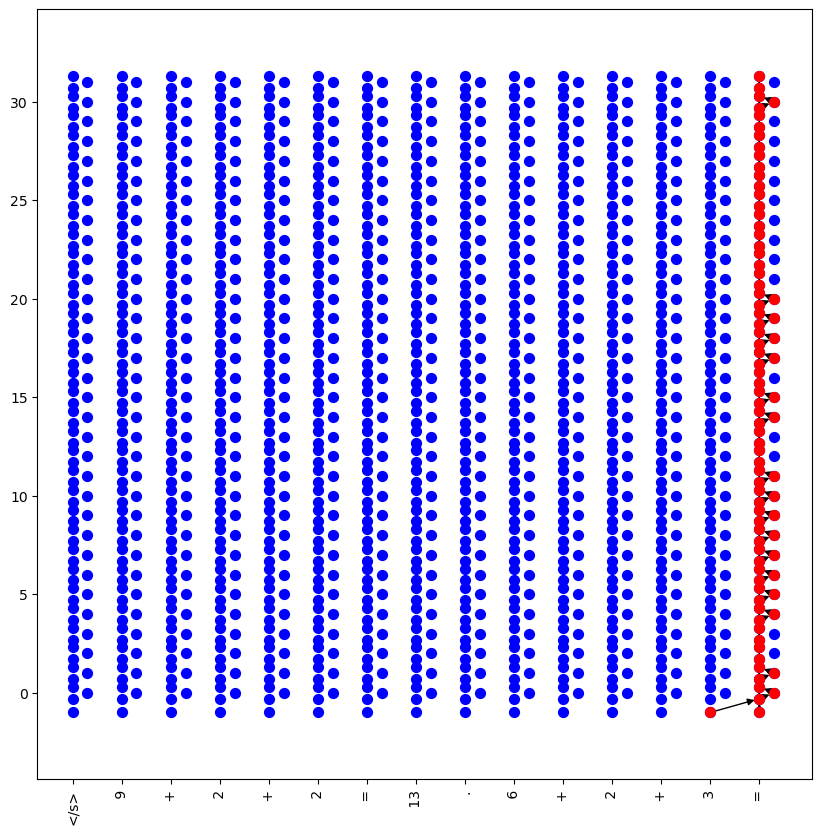

In [13]:
plot_single_graph(contribution_graphs[1][0], contribution_graphs[1][1], [tokenizer.decode(token) for token in contribution_graphs[1][2]])

In [14]:
all_operators = {'+', '-', '*', 'times', 'minus', 'plus'}
all_equal_signs = {'=', 'is'}

contribution_graphs_operands_operators = []

for item in contribution_graphs:
    # Extract the graph, path, and tokens
    graph, path, tokens = item[0].copy(), item[1].copy(), item[2]
    
    # Identify positions of numeric operands in the tokens
    operands_operators_positions = []
    for i, token in enumerate(tokens):
        token_decoded = tokenizer.decode(token)
        if token_decoded.strip() in all_operators or token_decoded.strip() in all_equal_signs or token_decoded.strip().isnumeric():
                operands_operators_positions.append(i)
    
    operands_operators_positions.append(len(tokens) - 1)
    
    # Identify nodes to remove from the graph (those not corresponding to operand positions)
    nodes_to_remove = []
    for node in list(graph.nodes):
        x_pos = int(node.split('_')[1])
        if x_pos not in operands_operators_positions:
            nodes_to_remove.append(node)

    graph.remove_nodes_from(nodes_to_remove)
    path.remove_nodes_from(nodes_to_remove)
    
    contribution_graphs_operands_operators.append((graph, path))

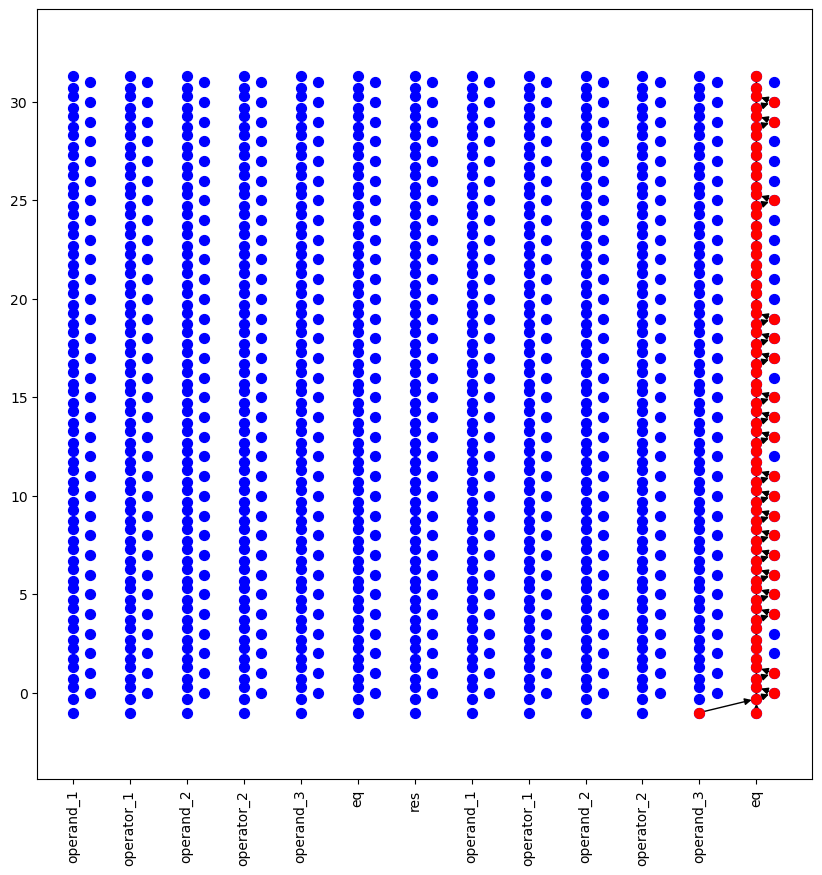

In [15]:
labels = ['operand_1', 'operator_1', 'operand_2', 'operator_2', 'operand_3', 'eq', 'res', 'operand_1', 'operator_1', 'operand_2', 'operator_2', 'operand_3', 'eq']
plot_single_graph(contribution_graphs_operands_operators[0][0],
                  contribution_graphs_operands_operators[0][1],
                  labels)

In [16]:
def plot_all_graphs(contribution_graphs, labels):
    plt.figure(figsize=(10, 10))

    whole_graph = contribution_graphs[0][0]
    positions = set_positions(whole_graph)
    nx.draw_networkx_nodes(whole_graph, node_color='blue', pos=positions, node_size=50, alpha=0.1)

    # Plot each individual path from the contribution graphs
    for item in tqdm(contribution_graphs):
        positions = set_positions(item[0])
        nx.draw(item[1], node_color='blue', pos=positions, node_size=50, alpha=0.1)

    plt.axis("on")
    plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
    plt.ylabel('Layer')
    plt.title('Information Flow Routes Importance Graph')
    plt.show()
    
    
def set_positions_transposed(graph):
    all_x_pos = [int(node.split('_')[1]) for node in graph.nodes]
    sorted_pos = sorted(set(all_x_pos))
    number_to_position = {num: idx for idx, num in enumerate(sorted_pos)}
    
    positions = {}
    for node in graph.nodes:
        x_pos =  number_to_position[int(node.split('_')[1])]
        y_pos = int(node.split('_')[0][1:])
        label = node.split('_')[0][0]
        if label == 'A':
            y_pos -= 0.3
        elif label == 'M':
            x_pos += 0.3
        elif label == 'I':
            y_pos += 0.3
        elif label == 'X':
            y_pos -= 1
        positions[node] = [y_pos, -x_pos]
    return positions
    
    
def plot_all_graphs_original_style(contribution_graphs, labels, save_path):
    # plt.rcParams['font.family'] = 'DeJavu Serif'
    # plt.rcParams['font.serif'] = ['Times New Roman']

    # Create a dataframe from the matrix
    labels = ['(1) ICE 1st operand', 
        '(+) ICE 1st operator', 
        '(3) ICE 2nd operand', 
        '(+) ICE 2nd operator', 
        '(4) ICE 3rd operand', 
        '(=) ICE Equal Sign', 
        '(8) ICE Result', 
        '(2) Task 1st operand', 
        '(+) Task 1st operator', 
        '(2) Task 2nd operand', 
        '(+) Task 2nd operator', 
        '(6) Task 3rd operand', 
        '(=) Task Equal Sign']
    
    plt.figure(figsize=(8, 6))
    
    whole_graph = contribution_graphs[0][0]
    positions = set_positions_transposed(whole_graph)
    nx.draw_networkx_nodes(whole_graph, cmap="Blues", pos=positions, node_size=50, alpha=0.1)

    # Plot each individual path from the contribution graphs
    for item in tqdm(contribution_graphs):
        positions = set_positions_transposed(item[0])
        nx.draw(item[1], cmap="Blues", pos=positions, node_size=50, alpha=0.1)
        
    
    plt.axis("on")
    plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    
    plt.xlabel('Layer', fontsize=16, fontname='DeJavu Serif')
    plt.title(f'Information Flow Routes Importance Graph', fontsize=16, fontname='DeJavu Serif')
    
    # plt.xticks(range(32))
    plt.yticks(ticks=range(-len(labels)+1, 1), labels=labels[::-1], fontsize=14, rotation=0)
    plt.xticks(fontsize=14)

    plt.gca().spines['top'].set_visible(False)   # Remove the top spine
    plt.gca().spines['right'].set_visible(False) # Remove the right spine
    plt.gca().spines['left'].set_visible(False)  # Remove the left spine
    plt.gca().spines['bottom'].set_visible(False) # Remove the bottom spine
    
    plt.savefig(save_path, format='png', bbox_inches='tight')
    
    # ax = plt.gca()
    # ax.set_xticks(range(32))
    
    # # # set x-axis labels to the range of unique layers
    # ax.set_xticklabels(range(32), fontsize=14, rotation=0)
    
    # for index, label in enumerate(ax.xaxis.get_ticklabels()):
    #     if index % 5 != 0:
    #         label.set_visible(False)

    # # Y-axis adjustments: Make labels horizontal and remove the y-axis title
    # ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)
    # ax.set_yticklabels(idx, fontsize=14)
    
    # plt.xlabel('Layer', fontsize=16, fontname='DeJavu Serif')
    # plt.ylabel('') # Remove y-axis title

    # # Title and other adjustments
    # plt.title(f'Patching Effect of the Residual Stream ', fontsize=16, fontname='DeJavu Serif')
    # plt.show()

  0%|          | 0/67 [00:00<?, ?it/s]

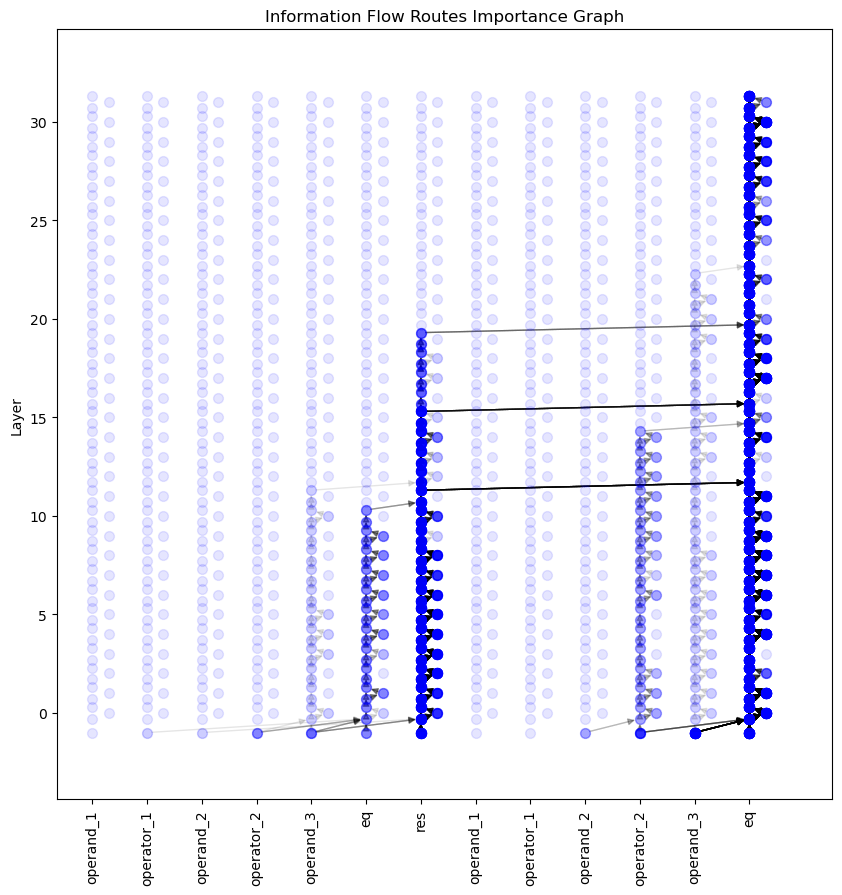

: 

In [ ]:
plot_all_graphs(contribution_graphs_operands_operators, labels)

/scratch_local/esx208-932061/ir_mech_interp/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


  0%|          | 0/67 [00:00<?, ?it/s]

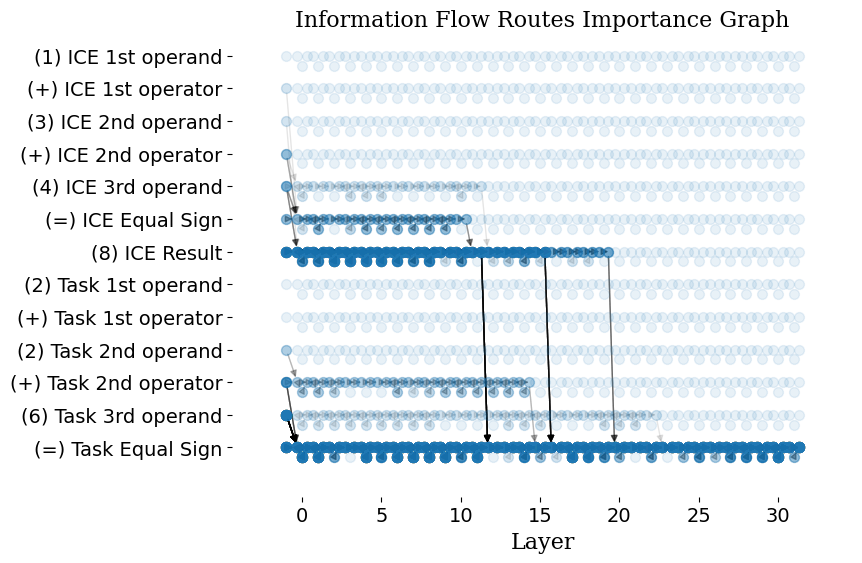

In [24]:
plot_all_graphs_original_style(contribution_graphs_operands_operators, labels, 
                               save_path='/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_6_7b/information_flow_routes_clean_examples_OPT_6_7.png')
                            #    save_path='/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_2_7b/information_flow_routes_clean_examples_OPT_2_7.png')

Let's try to access some features of the graph

In [30]:
# import llm_transparency_tool.routes.contributions as contributions

warnings.filterwarnings(action='once')

B0 = 0
layer = 10
head_contrib, _ = contributions.get_attention_contributions(
            resid_pre=model_transparent.residual_in(layer)[B0].unsqueeze(0),
            resid_mid=model_transparent.residual_after_attn(layer)[B0].unsqueeze(0),
            decomposed_attn=model_transparent.decomposed_attn(B0, layer).unsqueeze(0),
        )

2024-12-09 16:10:57.099 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-09 16:10:57.100 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-09 16:10:57.101 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-09 16:10:57.104 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-09 16:10:57.104 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-09 16:10:57.105 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-09 16:10:57.106 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-09 16:10:57.106 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

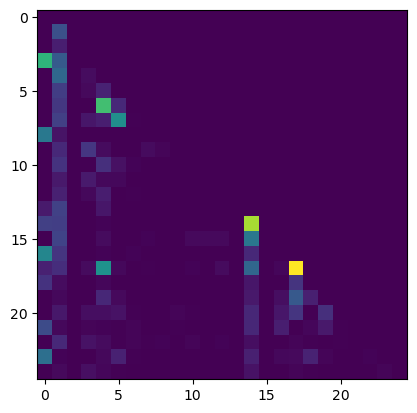

In [34]:
plt.imshow(head_contrib.squeeze()[:, :, -1].cpu())

In [33]:
head_contrib.squeeze().shape

torch.Size([25, 25, 32])

Let's also try to get the meta information of graph edges

In [48]:
for edge in graph.edges:
    print(edge)

('A0_5', 'M0_5')
('A0_5', 'I0_5')
('I0_5', 'A1_5')
('I0_5', 'A1_6')
('I0_5', 'A1_7')
('I0_5', 'A1_9')
('I0_5', 'A1_10')
('I0_5', 'A1_11')
('I0_5', 'A1_12')
('I0_5', 'A1_18')
('I0_5', 'A1_19')
('I0_5', 'A1_20')
('I0_5', 'A1_22')
('I0_5', 'A1_23')
('I0_5', 'A1_24')
('M0_5', 'I0_5')
('A0_6', 'M0_6')
('A0_6', 'I0_6')
('I0_6', 'A1_5')
('I0_6', 'A1_6')
('I0_6', 'A1_7')
('I0_6', 'A1_9')
('I0_6', 'A1_10')
('I0_6', 'A1_11')
('I0_6', 'A1_12')
('I0_6', 'A1_18')
('I0_6', 'A1_19')
('I0_6', 'A1_20')
('I0_6', 'A1_22')
('I0_6', 'A1_23')
('I0_6', 'A1_24')
('M0_6', 'I0_6')
('A0_7', 'M0_7')
('A0_7', 'I0_7')
('I0_7', 'A1_5')
('I0_7', 'A1_6')
('I0_7', 'A1_7')
('I0_7', 'A1_9')
('I0_7', 'A1_10')
('I0_7', 'A1_11')
('I0_7', 'A1_12')
('I0_7', 'A1_18')
('I0_7', 'A1_19')
('I0_7', 'A1_20')
('I0_7', 'A1_22')
('I0_7', 'A1_23')
('I0_7', 'A1_24')
('M0_7', 'I0_7')
('A0_9', 'M0_9')
('A0_9', 'I0_9')
('I0_9', 'A1_5')
('I0_9', 'A1_6')
('I0_9', 'A1_7')
('I0_9', 'A1_9')
('I0_9', 'A1_10')
('I0_9', 'A1_11')
('I0_9', 'A1_12')
(

In [54]:
contribution_graphs[0][0].get_edge_data('A20_0', 'M20_0')

{'weight': 0.0}

In [6]:
def plot_single_graph_edge_transparency(graph, tokens):
    positions = set_positions(graph)

    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(graph, node_color='blue', pos=positions, node_size=50)
    [nx.draw_networkx_edges(graph, pos=positions, edgelist=[(node_1, node_2)], alpha=np.clip(graph.get_edge_data(node_1, node_2)['weight'] * 10, 0, 1)) for (node_1, node_2) in graph.edges]

    plt.axis("on")
    plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.xticks(ticks=range(len(tokens)), labels=tokens, rotation=90)
    plt.show()

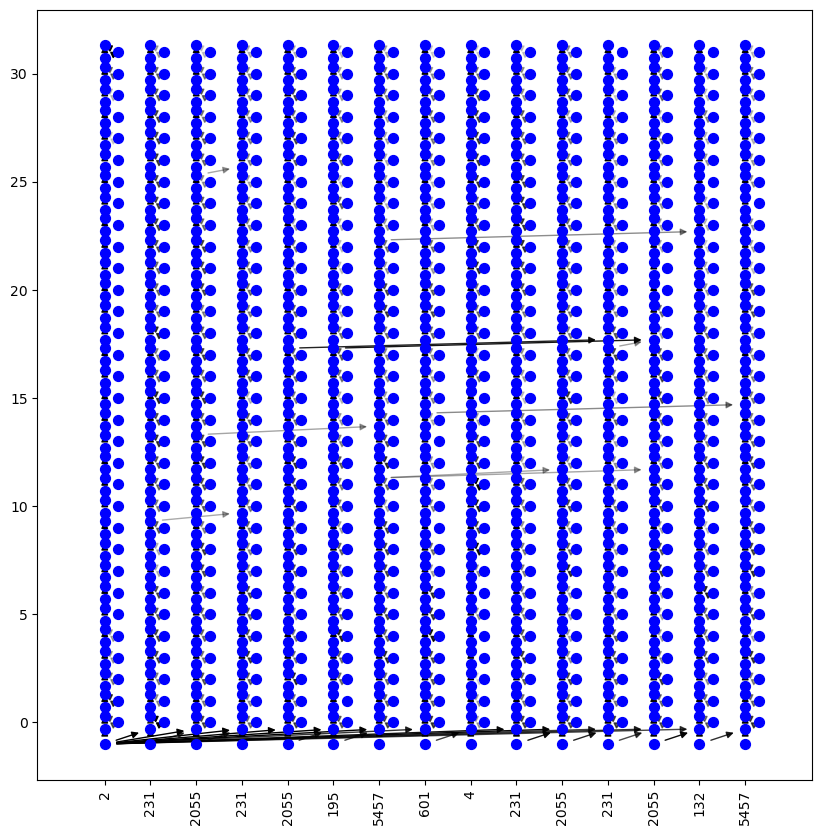

In [ ]:
plot_single_graph_edge_transparency(contribution_graphs[0][0], [tokenizer.decode(token)contribution_graphs[0][-1])

Let's try to run an experiment for the Appendix.

For each example we will find graphs for \tau in range [0.01, 0.05]

In [97]:
defaultdict(0)

TypeError: first argument must be callable or None

In [55]:
# threshold = 0.1
# contribution_graphs = []

# for i, item in enumerate(tqdm(accuracy_base)):
#     if item == 1:  # Only process cases where the prediction is correct
#         # Construct the input message
#         msg = ' ' + intervention_list[i].few_shots + intervention_list[i].base_string
#         model_transparent.run(msg)
#         graph = build_full_graph(model_transparent, renormalizing_threshold=threshold)
        
#         tokens = model_transparent.tokens()[0]
#         n_tokens = tokens.shape[0]
#         model_info = model_transparent.model_info()
#         paths = build_paths_to_predictions(
#             graph,
#             model_info.n_layers,
#             n_tokens,
#             range(n_tokens),
#             threshold,
#         )
        
#         contribution_graphs.append((graph.copy(), paths[-1], tokens.cpu().numpy()))

from collections import defaultdict
import os
import logging

# Suppress specific warnings related to ScriptRunContext
warnings.filterwarnings("ignore", message=".*ScriptRunContext.*")

# Set the log level of Streamlit to prevent info and warning messages from being displayed
os.environ["STREAMLIT_LOG_LEVEL"] = "error"

# Optionally, adjust logging for torch and other libraries
logging.getLogger("torch").setLevel(logging.ERROR)
logging.getLogger("streamlit").setLevel(logging.ERROR)

        
threshold_range = np.linspace(0.01, 0.04, 10)
res = []
for i, item in enumerate(tqdm(accuracy_base)):
    if item == 1:
        msg = ' ' + intervention_list[i].few_shots + intervention_list[i].base_string
        model_transparent.run(msg)
        tokens = model_transparent.tokens()[0]
        n_tokens = tokens.shape[0]
        model_info = model_transparent.model_info()
        node_activation_dict = defaultdict(int)
        for threshold in threshold_range:
            graph = build_full_graph(model_transparent, renormalizing_threshold=threshold)
            path = build_paths_to_predictions(
                graph,
                model_info.n_layers,
                n_tokens,
                range(n_tokens),
                threshold,
            )[-1]
            
            operands_operators_positions = []
            for i, token in enumerate(tokens):
                token_decoded = tokenizer.decode(token)
                if token_decoded.strip() in all_operators or token_decoded.strip() in all_equal_signs or token_decoded.strip().isnumeric():
                        operands_operators_positions.append(i)
            
            if len(tokens)-1 not in operands_operators_positions:
                operands_operators_positions.append(len(tokens) - 1)
            
            # Identify nodes to remove from the graph (those not corresponding to operand positions)
            nodes_to_remove = []
            for node in list(graph.nodes):
                x_pos = int(node.split('_')[1])
                if x_pos not in operands_operators_positions:
                    nodes_to_remove.append(node)
                    
            graph.remove_nodes_from(nodes_to_remove)
            path.remove_nodes_from(nodes_to_remove)
            
            operands_operators_positions_correspondance = {operands_operators_positions[i]: i for i in range(len(operands_operators_positions))}
            nodes_correspondance = dict()
            for node in graph:
                x_pos = int(node.split('_')[1])
                x_pos_new = operands_operators_positions_correspondance[x_pos]
                node_new = node.split('_')[0] + '_' + str(x_pos_new)
                nodes_correspondance[node] = node_new
                
            graph = nx.relabel_nodes(graph, nodes_correspondance)
            path = nx.relabel_nodes(path, nodes_correspondance)
            
            for node in path:
                node_activation_dict[node] = max(node_activation_dict[node], threshold)
        res.append((graph, path, node_activation_dict))

        # node_activation_dict
        # print(node_activation_dict)
# threshold_range

  0%|          | 0/210 [00:00<?, ?it/s]

In [ ]:
# torch.save(res, '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_6_7b/graphs_thresholds_opt_6_7.pkl')

In [27]:
res = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_6_7b/graphs_thresholds_opt_6_7.pkl')

/tmp/ipykernel_699961/2254728773.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_route

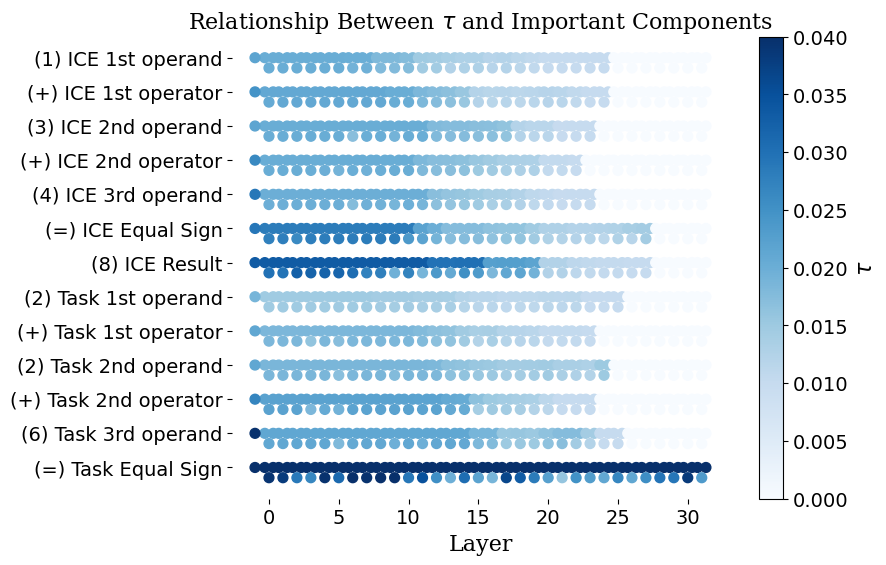

In [29]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from collections import defaultdict

fig, ax = plt.subplots(figsize=(8, 6))

# Create a dataframe from the matrix
labels = ['(1) ICE 1st operand', 
    '(+) ICE 1st operator', 
    '(3) ICE 2nd operand', 
    '(+) ICE 2nd operator', 
    '(4) ICE 3rd operand', 
    '(=) ICE Equal Sign', 
    '(8) ICE Result', 
    '(2) Task 1st operand', 
    '(+) Task 1st operator', 
    '(2) Task 2nd operand', 
    '(+) Task 2nd operator', 
    '(6) Task 3rd operand', 
    '(=) Task Equal Sign']

node_activation_all = defaultdict(list)
for item in res:
    nodes_correspondance_curr = item[-1]
    for key in nodes_correspondance_curr:
        node_activation_all[key].append(nodes_correspondance_curr[key])
        
for key in node_activation_all:
    node_activation_all[key] = np.mean(node_activation_all[key])

graph = res[0][0]
node_colors = [node_activation_all[node] if node_activation_all[node] else 0 for node in graph]

cmap = plt.cm.Blues
norm = Normalize(vmin=min(node_colors), vmax=max(node_colors))

positions = set_positions_transposed(graph)
nx.draw_networkx_nodes(graph, node_color=node_colors, pos=positions, cmap=cmap, node_size=50)

# Add the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array for colorbar
colorbar = fig.colorbar(sm, ax=ax)
colorbar.ax.tick_params(labelsize=14)
colorbar.set_label('$\\tau$', fontsize=16)

plt.axis("on")
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.xlabel('Layer', fontsize=16, fontname='DeJavu Serif')
plt.title(f'Relationship Between $\\tau$ and Important Components', fontsize=16, fontname='DeJavu Serif')

# plt.xticks(range(32))
plt.yticks(ticks=range(-len(labels)+1, 1), labels=labels[::-1], fontsize=14, rotation=0)
plt.xticks(fontsize=14)

plt.gca().spines['top'].set_visible(False)   # Remove the top spine
plt.gca().spines['right'].set_visible(False) # Remove the right spine
plt.gca().spines['left'].set_visible(False)  # Remove the left spine
plt.gca().spines['bottom'].set_visible(False) # Remove the bottom spine

plt.savefig('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_6_7b/information_flow_routes_hyperparameter_OPT_6_7.png', format='png', bbox_inches='tight')

In [42]:
node_colors

[np.float64(0.016666666666666666),
 np.float64(0.016666666666666666),
 np.float64(0.016666666666666666),
 np.float64(0.018333333333333337),
 np.float64(0.018333333333333337),
 np.float64(0.018333333333333337),
 np.float64(0.015),
 np.float64(0.015),
 np.float64(0.015),
 np.float64(0.015),
 np.float64(0.015),
 np.float64(0.015),
 np.float64(0.013333333333333334),
 np.float64(0.013333333333333334),
 np.float64(0.013333333333333334),
 np.float64(0.02),
 np.float64(0.02),
 np.float64(0.02),
 np.float64(0.028333333333333335),
 np.float64(0.028333333333333335),
 np.float64(0.028333333333333335),
 np.float64(0.011666666666666667),
 np.float64(0.011666666666666667),
 np.float64(0.011666666666666667),
 np.float64(0.02),
 np.float64(0.02),
 np.float64(0.02),
 np.float64(0.018333333333333337),
 np.float64(0.018333333333333337),
 np.float64(0.018333333333333337),
 np.float64(0.016666666666666666),
 np.float64(0.016666666666666666),
 np.float64(0.016666666666666666),
 np.float64(0.01666666666666666

In [39]:
node_activation_all

defaultdict(list,
            {'A0_0': np.float64(0.016666666666666666),
             'I0_0': np.float64(0.016666666666666666),
             'M0_0': np.float64(0.016666666666666666),
             'A0_1': np.float64(0.018333333333333337),
             'I0_1': np.float64(0.018333333333333337),
             'M0_1': np.float64(0.018333333333333337),
             'A0_2': np.float64(0.015),
             'I0_2': np.float64(0.015),
             'M0_2': np.float64(0.015),
             'A0_3': np.float64(0.015),
             'I0_3': np.float64(0.015),
             'M0_3': np.float64(0.015),
             'A0_4': np.float64(0.013333333333333334),
             'I0_4': np.float64(0.013333333333333334),
             'M0_4': np.float64(0.013333333333333334),
             'A0_5': np.float64(0.02),
             'I0_5': np.float64(0.02),
             'M0_5': np.float64(0.02),
             'A0_6': np.float64(0.028333333333333335),
             'I0_6': np.float64(0.028333333333333335),
             'M0_6':

In [29]:
node_activation_all

defaultdict(list,
            {'A0_0': np.float64(0.016666666666666666),
             'I0_0': np.float64(0.016666666666666666),
             'M0_0': np.float64(0.016666666666666666),
             'A0_1': np.float64(0.018333333333333337),
             'I0_1': np.float64(0.018333333333333337),
             'M0_1': np.float64(0.018333333333333337),
             'A0_2': np.float64(0.015),
             'I0_2': np.float64(0.015),
             'M0_2': np.float64(0.015),
             'A0_3': np.float64(0.015),
             'I0_3': np.float64(0.015),
             'M0_3': np.float64(0.015),
             'A0_4': np.float64(0.013333333333333334),
             'I0_4': np.float64(0.013333333333333334),
             'M0_4': np.float64(0.013333333333333334),
             'A0_5': np.float64(0.02),
             'I0_5': np.float64(0.02),
             'M0_5': np.float64(0.02),
             'A0_6': np.float64(0.028333333333333335),
             'I0_6': np.float64(0.028333333333333335),
             'M0_6':

In [22]:
np.mean(node_correspondance_all['A0_1'])

np.float64(0.0)

In [96]:
node_activation_dict

defaultdict(list,
            {'A0_1': [np.float64(0.01),
              np.float64(0.012105263157894737),
              np.float64(0.014210526315789474),
              np.float64(0.01631578947368421)],
             'I0_1': [np.float64(0.01),
              np.float64(0.012105263157894737),
              np.float64(0.014210526315789474),
              np.float64(0.01631578947368421)],
             'M0_1': [np.float64(0.01),
              np.float64(0.012105263157894737),
              np.float64(0.014210526315789474),
              np.float64(0.01631578947368421)],
             'A0_2': [np.float64(0.01),
              np.float64(0.012105263157894737),
              np.float64(0.014210526315789474),
              np.float64(0.01631578947368421)],
             'I0_2': [np.float64(0.01),
              np.float64(0.012105263157894737),
              np.float64(0.014210526315789474),
              np.float64(0.01631578947368421)],
             'M0_2': [np.float64(0.01),
              np.float

In [ ]:
For each 

Let's try to get contribution of each component following the Ruochen's approach

In [ ]:
# import llm_transparency_tool
# from llm_transparency_tool.models.tlens_model import (TransformerLensTransparentLlm)
# import pandas as pd
# import llm_transparency_tool.routes
# import llm_transparency_tool.routes.graph
# import llm_transparency_tool.routes.contributions as contributions
# import torch
# from tqdm import tqdm
# import warnings
# import os
# import logging
# import warnings
# import streamlit as st
# import json

# # Suppress specific warnings related to ScriptRunContext
# warnings.filterwarnings("ignore", message=".*ScriptRunContext.*")

# # Set the log level of Streamlit to prevent info and warning messages from being displayed
# os.environ["STREAMLIT_LOG_LEVEL"] = "error"

# # Optionally, adjust logging for torch and other libraries
# logging.getLogger("torch").setLevel(logging.ERROR)
# logging.getLogger("streamlit").setLevel(logging.ERROR)

# ioi_en = pd.read_csv('../Circuit_Over_Language/data_dup/tense_en.csv')
# inputs = ioi_en['input_text'].tolist()
# model = TransformerLensTransparentLlm("bloom-560m")
# n_layers = 24
# n_heads = 16
# batch_i = 0

# heads_per_instance = {}
# for idx in tqdm(range(len(inputs))):
#     text = inputs[idx]
#     model._model.reset_hooks()
#     model.run(text)
#     tokens_size = model._model.to_tokens(text).shape[-1]
#     pos_idx_pairs = [(src, tgt) for src in range(tokens_size) for tgt in range(src, tokens_size)]
#     contribution_threshold = 0.03
#     important_heads = []
#     for layer in range(n_layers):
#         for src_token_idx, target_token_idx in pos_idx_pairs:
#             # print(src_token_idx, target_token_idx, layer)
#             head_contrib, c_resid_attn = contributions.get_attention_contributions(
#                 resid_pre=model.residual_in(layer)[0].unsqueeze(0),
#                 resid_mid=model.residual_after_attn(layer)[0].unsqueeze(0),
#                 decomposed_attn=model.decomposed_attn(0, layer).unsqueeze(0),
#             )
#             flat_contrib = head_contrib[0, target_token_idx, src_token_idx, :]
#             important_head_idx = torch.nonzero(flat_contrib > contribution_threshold, as_tuple=False).squeeze(-1).tolist()
#             # print(important_head_idx)
#             if important_head_idx != []:
#                 for head_idx in important_head_idx:
#                     important_heads.append((layer, head_idx))
#     heads_per_instance[idx] = important_heads

# with open('tense_en_heads_bloom.json', 'w') as f:
#     json.dump(heads_per_instance, f)

In [80]:
import os
import logging
import llm_transparency_tool.routes.contributions as contributions

# Suppress specific warnings related to ScriptRunContext
warnings.filterwarnings("ignore", message=".*ScriptRunContext.*")

# Set the log level of Streamlit to prevent info and warning messages from being displayed
os.environ["STREAMLIT_LOG_LEVEL"] = "error"

# Optionally, adjust logging for torch and other libraries
logging.getLogger("torch").setLevel(logging.ERROR)
logging.getLogger("streamlit").setLevel(logging.ERROR)

all_operators = {'+', '-', '*', 'times', 'minus', 'plus'}
all_equal_signs = {'=', 'is'}

all_contribution_matrices_c_ffn = []
all_contribution_matrices_c_resid_ffn = []
all_tokens = []
for i, item in enumerate(tqdm(accuracy_base)):
    if item == 1:
        msg = ' ' + intervention_list[i].few_shots + intervention_list[i].base_string
        model_transparent._model.reset_hooks()
        model_transparent.run(msg)
        tokens = model_transparent._model.to_tokens(msg)[0]
        tokens_size = model_transparent._model.to_tokens(msg).shape[-1]
        pos_idx_pairs = [(src, tgt) for src in range(tokens_size) for tgt in range(src, tokens_size)]
        n_layers = model_transparent.model_info().n_layers
        # graph = build_full_graph(model_transparent, renormalizing_threshold=threshold)
        contribution_matrix_c_ffn = []
        contribution_matrix_c_resid_ffn = []
        for layer in range(n_layers):
            c_ffn, c_resid_ffn = contributions.get_mlp_contributions(
                resid_mid=model_transparent.residual_after_attn(layer)[0].unsqueeze(0),
                resid_post=model_transparent.residual_out(layer)[0].unsqueeze(0),
                mlp_out=model_transparent.ffn_out(layer)[0].unsqueeze(0),
            )
            contribution_matrix_c_ffn.append(c_ffn)
            contribution_matrix_c_resid_ffn.append(c_resid_ffn)
        
        operands_operators_positions = []
        for i, token in enumerate(tokens):
            token_decoded = tokenizer.decode(token)
            print(token_decoded)
            if token_decoded.strip() in all_operators or token_decoded.strip() in all_equal_signs or token_decoded.strip().isnumeric():
                operands_operators_positions.append(i)
    
        if len(tokens)-1 not in operands_operators_positions:
            operands_operators_positions.append(len(tokens) - 1)
        
        contribution_matrix_c_ffn = torch.cat(contribution_matrix_c_ffn).cpu()[:, operands_operators_positions,]
        contribution_matrix_c_resid_ffn = torch.cat(contribution_matrix_c_resid_ffn).cpu()[:, operands_operators_positions]
        
        all_contribution_matrices_c_ffn.append(contribution_matrix_c_ffn)
        all_contribution_matrices_c_resid_ffn.append(contribution_matrix_c_resid_ffn)    

  0%|          | 0/210 [00:00<?, ?it/s]

2024-12-08 23:56:09.551 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:09.552 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:09.552 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:09.553 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:09.554 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:09.559 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:09.560 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:09.560 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

2024-12-08 23:56:09.652 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:09.653 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:09.653 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:09.655 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:09.656 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:09.657 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:09.657 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:09.658 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 6
 +
 6
 +
 5
 =
 17
.
 6
 +
 6
 +
 2
 =
</s>
 7
 +
 2
 +
 10
 =
 19
.
 6
 +
 2
 +
 4
 =


2024-12-08 23:56:09.906 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:09.906 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:09.907 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:09.908 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:09.908 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:09.909 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:09.910 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:09.910 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 The
 result
 of
 9
 +
 4
 +
 6
 =
 19
.
 The
 result
 of
 8
 +
 4
 +
 3
 =
</s>
 The
 result
 of
 7
 +
 5
 +
 3
 =
 15
.
 The
 result
 of
 2
 +
 7
 +
 6
 =


2024-12-08 23:56:10.153 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.153 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.154 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.155 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.156 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.157 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.157 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.158 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 The
 result
 of
 7
 +
 6
 +
 2
 =
 15
.
 The
 result
 of
 3
 +
 3
 +
 3
 =
</s>
 The
 result
 of
 4
 +
 10
 +
 3
 =
 17
.
 The
 result
 of
 10
 +
 3
 +
 4
 =


2024-12-08 23:56:10.395 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.396 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.396 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.398 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.398 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.399 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.399 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.400 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 The
 result
 of
 4
 +
 4
 +
 4
 =
 12
.
 The
 result
 of
 11
 +
 6
 +
 2
 =
</s>
 The
 result
 of
 17
 minus
 4
 minus
 8
 is
 5
.
 The
 result
 of
 17
 minus
 5
 minus
 8
 is


2024-12-08 23:56:10.628 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.628 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.628 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.629 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.630 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.631 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.631 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.631 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 The
 result
 of
 19
 minus
 12
 minus
 5
 is
 2
.
 The
 result
 of
 18
 minus
 3
 minus
 12
 is
</s>
 The
 result
 of
 2
 *
 3
 *
 2
 =
 12
.
 The
 result
 of
 2
 *
 2
 *
 3
 =


2024-12-08 23:56:10.857 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.857 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.858 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.859 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.860 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.861 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.861 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:10.862 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 The
 result
 of
 2
 *
 2
 *
 3
 =
 12
.
 The
 result
 of
 3
 *
 2
 *
 2
 =
</s>
 The
 result
 of
 2
 *
 3
 *
 3
 =
 18
.
 The
 result
 of
 4
 *
 2
 *
 2
 =


2024-12-08 23:56:11.092 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.093 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.093 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.095 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.095 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.096 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.097 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.097 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 The
 result
 of
 3
 *
 3
 *
 2
 =
 18
.
 The
 result
 of
 2
 *
 3
 *
 3
 =
</s>
 The
 result
 of
 3
 *
 3
 *
 2
 =
 18
.
 The
 result
 of
 2
 *
 2
 *
 4
 =


2024-12-08 23:56:11.319 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.320 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.320 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.321 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.321 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.322 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.323 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.323 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 The
 result
 of
 3
 *
 2
 *
 3
 =
 18
.
 The
 result
 of
 3
 *
 3
 *
 2
 =
</s>
 The
 result
 of
 2
 *
 3
 *
 2
 =
 12
.
 The
 result
 of
 2
 *
 2
 *
 3
 =


2024-12-08 23:56:11.551 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.551 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.551 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.552 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.552 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.553 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.553 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.554 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 The
 result
 of
 3
 *
 3
 *
 2
 =
 18
.
 The
 result
 of
 2
 *
 4
 *
 2
 =
</s>
 The
 result
 of
 3
 *
 2
 *
 2
 =
 12
.
 The
 result
 of
 2
 *
 2
 *
 4
 =


2024-12-08 23:56:11.797 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.798 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.798 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.800 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.800 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.801 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.802 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:11.802 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 The
 result
 of
 2
 *
 2
 *
 3
 =
 12
.
 The
 result
 of
 2
 *
 3
 *
 2
 =
</s>
 The
 result
 of
 3
 *
 3
 *
 2
 =
 18
.
 The
 result
 of
 3
 *
 3
 *
 2
 =


2024-12-08 23:56:12.467 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:12.468 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:12.468 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:12.469 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:12.470 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:12.470 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:12.471 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:12.471 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 The
 result
 of
 2
 *
 3
 *
 3
 =
 18
.
 The
 result
 of
 4
 *
 2
 *
 2
 =
</s>
 The
 result
 of
 2
 *
 2
 *
 2
 =
 8
.
 The
 result
 of
 4
 *
 2
 *
 2
 =


2024-12-08 23:56:12.694 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:12.694 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:12.695 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:12.696 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:12.696 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:12.697 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:12.697 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:12.698 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 The
 result
 of
 3
 *
 2
 *
 3
 =
 18
.
 The
 result
 of
 2
 *
 3
 *
 3
 =
</s>
 The
 result
 of
 2
 *
 3
 *
 2
 =
 12
.
 The
 result
 of
 2
 *
 3
 *
 2
 =


2024-12-08 23:56:12.920 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:12.920 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:12.921 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:12.922 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:12.922 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:12.923 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:12.923 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:12.923 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 The
 result
 of
 2
 times
 3
 times
 3
 =
 18
.
 The
 result
 of
 3
 times
 3
 times
 2
 =
</s>
 The
 result
 of
 3
 times
 2
 times
 3
 =
 18
.
 The
 result
 of
 3
 times
 3
 times
 2
 =


2024-12-08 23:56:13.154 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.154 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.155 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.156 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.156 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.157 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.157 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.158 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 The
 result
 of
 3
 times
 3
 times
 2
 =
 18
.
 The
 result
 of
 2
 times
 3
 times
 3
 =
</s>
 The
 result
 of
 2
 times
 2
 times
 2
 =
 8
.
 The
 result
 of
 2
 times
 2
 times
 2
 =


2024-12-08 23:56:13.385 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.386 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.386 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.388 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.388 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.389 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.389 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.389 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 The
 result
 of
 4
 times
 2
 times
 2
 =
 16
.
 The
 result
 of
 2
 times
 2
 times
 2
 =
</s>
 2
 *
 2
 *
 3
 =
 12
.
 2
 *
 2
 *
 3
 =


2024-12-08 23:56:13.617 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.618 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.618 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.619 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.620 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.620 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.621 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.621 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 2
 *
 2
 *
 2
 =
 8
.
 2
 *
 2
 *
 2
 =
</s>
 2
 *
 3
 *
 2
 =
 12
.
 2
 *
 2
 *
 2
 =


2024-12-08 23:56:13.848 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.848 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.849 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.850 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.850 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.851 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.851 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:13.852 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 2
 *
 2
 *
 4
 =
 16
.
 2
 *
 4
 *
 2
 =
</s>
 2
 *
 2
 *
 4
 =
 16
.
 2
 *
 2
 *
 2
 =


2024-12-08 23:56:14.081 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.081 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.082 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.083 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.083 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.084 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.084 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.085 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 4
 *
 2
 *
 2
 =
 16
.
 2
 *
 4
 *
 2
 =
</s>
 3
 *
 2
 *
 3
 =
 18
.
 3
 *
 3
 *
 2
 =


2024-12-08 23:56:14.316 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.317 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.317 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.319 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.319 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.320 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.320 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.320 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 3
 *
 3
 *
 2
 =
 18
.
 3
 *
 3
 *
 2
 =
</s>
 4
 *
 2
 *
 2
 =
 16
.
 2
 *
 2
 *
 4
 =


2024-12-08 23:56:14.550 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.551 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.551 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.552 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.552 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.553 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.554 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.554 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 The
 result
 of
 (
 15
 -
 14
 )
 *
 9
 =
 9
.
 The
 result
 of
 (
 15
 -
 14
 )
 *
 12
 =
</s>
 The
 result
 of
 (
 18
 -
 17
 )
 *
 6
 =
 6
.
 The
 result
 of
 (
 6
 -
 5
 )
 *
 3
 =


2024-12-08 23:56:14.778 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.779 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.779 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.780 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.780 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.781 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.781 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:14.782 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 The
 result
 of
 (
 3
 -
 2
 )
 *
 16
 =
 16
.
 The
 result
 of
 (
 20
 -
 19
 )
 *
 16
 =
</s>
 The
 result
 of
 (
 20
 -
 15
 )
 *
 2
 =
 10
.
 The
 result
 of
 (
 18
 -
 14
 )
 *
 4
 =


2024-12-08 23:56:15.010 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:15.011 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:15.011 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:15.012 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:15.013 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:15.014 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:15.014 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:15.014 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 The
 result
 of
 (
 20
 -
 19
 )
 *
 6
 =
 6
.
 The
 result
 of
 (
 6
 -
 5
 )
 *
 14
 =


2024-12-08 23:56:15.542 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:15.543 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:15.543 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:15.544 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:15.544 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:15.545 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:15.545 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:15.546 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 The
 result
 of
 (
 8
 -
 6
 )
 *
 3
 =
 6
.
 The
 result
 of
 (
 8
 -
 7
 )
 *
 6
 =
</s>
 The
 result
 of
 (
 16
 -
 14
 )
 *
 7
 =
 14
.
 The
 result
 of
 (
 3
 -
 2
 )
 *
 18
 =


2024-12-08 23:56:15.767 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:15.767 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:15.768 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:15.768 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:15.768 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:15.769 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:15.770 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 23:56:15.770 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

</s>
 The
 result
 of
 (
 11
 -
 10
 )
 *
 15
 =
 15
.
 The
 result
 of
 (
 11
 -
 10
 )
 *
 14
 =


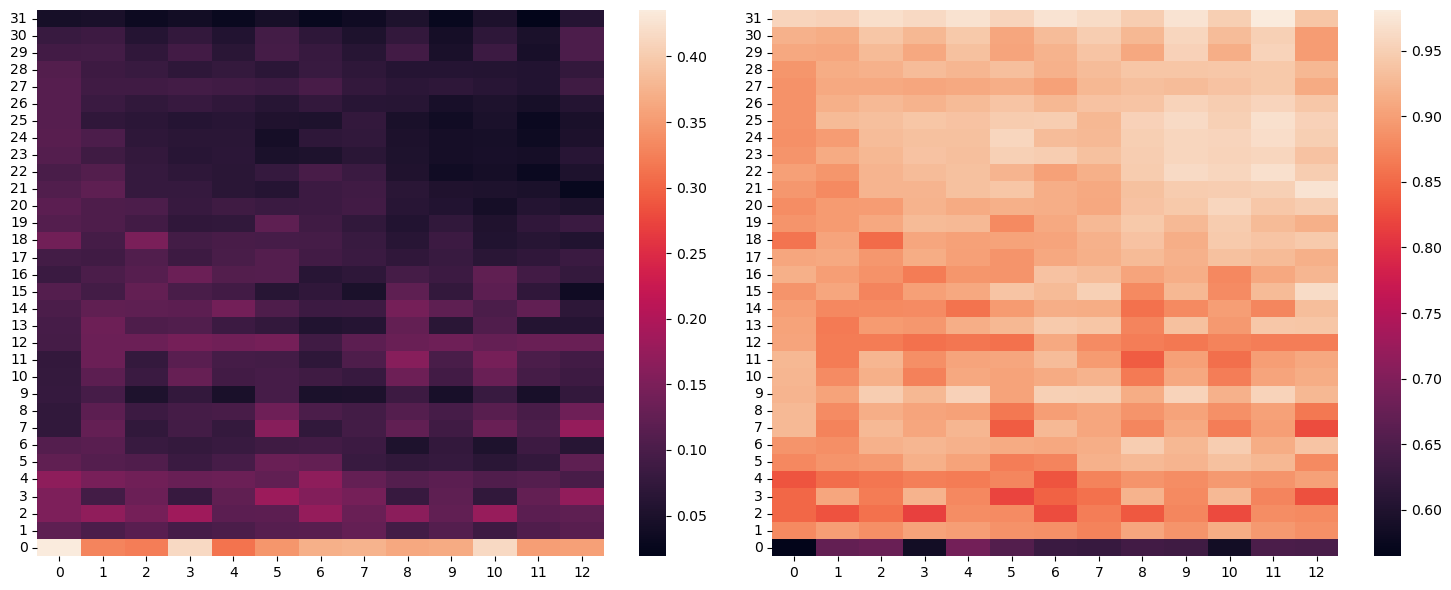

In [90]:
plt.figure(figsize=(15,6))
plt.subplot(121)
sns.heatmap(torch.mean(torch.stack(all_contribution_matrices_c_ffn), dim=0))
plt.gca().invert_yaxis()
plt.subplot(122)
sns.heatmap(torch.mean(torch.stack(all_contribution_matrices_c_resid_ffn), dim=0))
plt.gca().invert_yaxis()
plt.tight_layout()

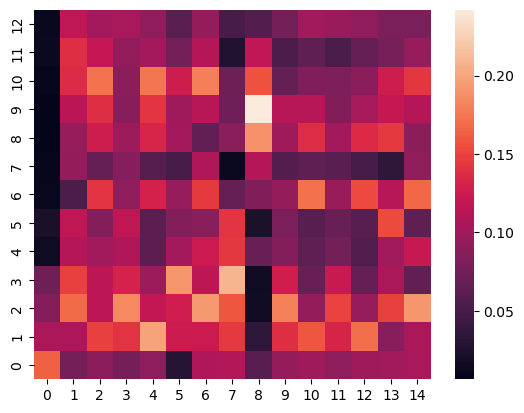

In [79]:
plt.figure()
sns.heatmap(all_contribution_matrices_c_ffn[0])
plt.gca().invert_yaxis()

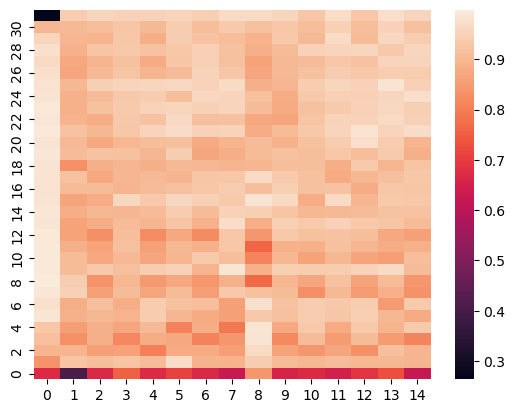

In [65]:
plt.figure()
sns.heatmap(all_contribution_matrices_c_resid_ffn[0])
plt.gca().invert_yaxis()

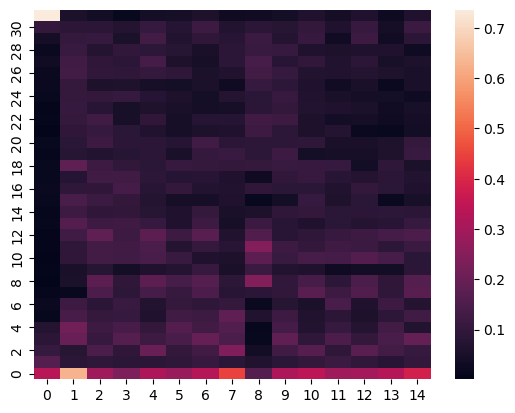

In [66]:
plt.figure()
sns.heatmap(all_contribution_matrices_c_ffn[1])
plt.gca().invert_yaxis()

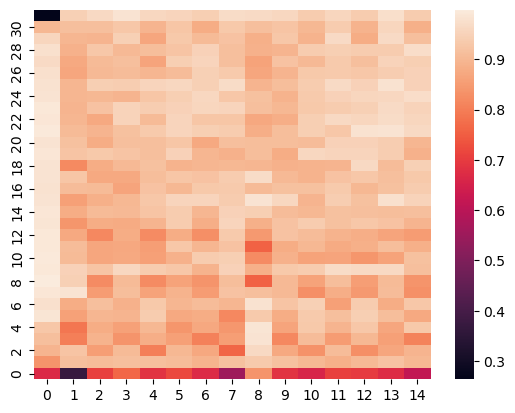

In [67]:
plt.figure()
sns.heatmap(all_contribution_matrices_c_resid_ffn[1])
plt.gca().invert_yaxis()

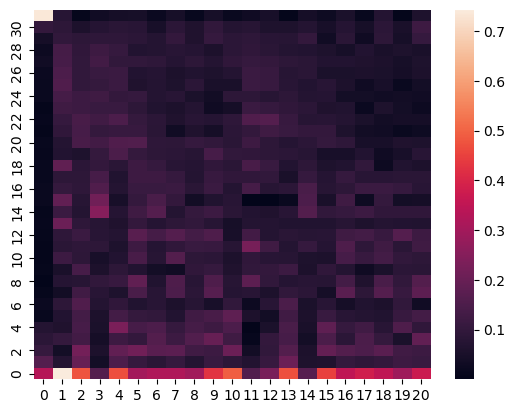

In [68]:
plt.figure()
sns.heatmap(all_contribution_matrices_c_ffn[2])
plt.gca().invert_yaxis()

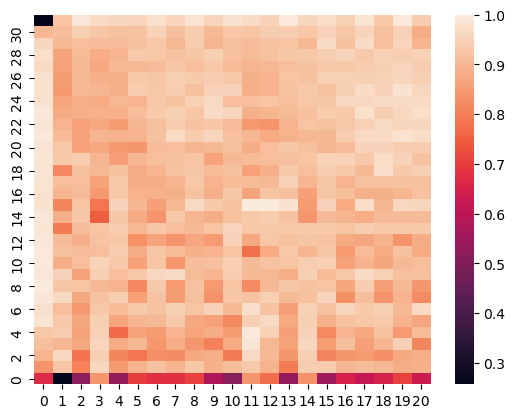

In [69]:
plt.figure()
sns.heatmap(all_contribution_matrices_c_resid_ffn[2])
plt.gca().invert_yaxis()

In [ ]:
threshold = 0.1
contribution_graphs = []

for i, item in enumerate(tqdm(accuracy_base)):
    if item == 1:  # Only process cases where the prediction is correct
        # Construct the input message
        msg = ' ' + intervention_list[i].few_shots + intervention_list[i].base_string
        model_transparent.run(msg)
        graph = build_full_graph(model_transparent, renormalizing_threshold=threshold)
        
        tokens = model_transparent.tokens()[0]
        n_tokens = tokens.shape[0]
        model_info = model_transparent.model_info()
        paths = build_paths_to_predictions(
            graph,
            model_info.n_layers,
            n_tokens,
            range(n_tokens),
            threshold,
        )
        
        contribution_graphs.append((graph.copy(), paths[-1], tokens.cpu().numpy()))